In [1]:

# import os
# os.chdir('/content/MultiTradingEnv/MultiTrading/RL-Final-Env')
# print(os.getcwd())
from Env import MultiTradingEnv,State,Action
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import argparse
import gym
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
from torch.distributions import Categorical
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
stocks=['63MOONS.csv','NHPC.csv','BIOCON.csv','BHEL.csv']
# stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']

dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
timesteps=1000
for name in stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    dataframes.append(df)


In [3]:

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_low"] = data["Low"]/data["Close"]
    # data["feature_Volume"] = data["Volume"] / data["Volume"].rolling(7*24).max()
    data.dropna(inplace=True)
    data.reset_index(inplace=True,drop=True)


In [4]:
norm_dataframes=[]
for i in range(len(dataframes)):
    df=dataframes[i]
    preprocess(df)
    dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_dataframes.append(df)

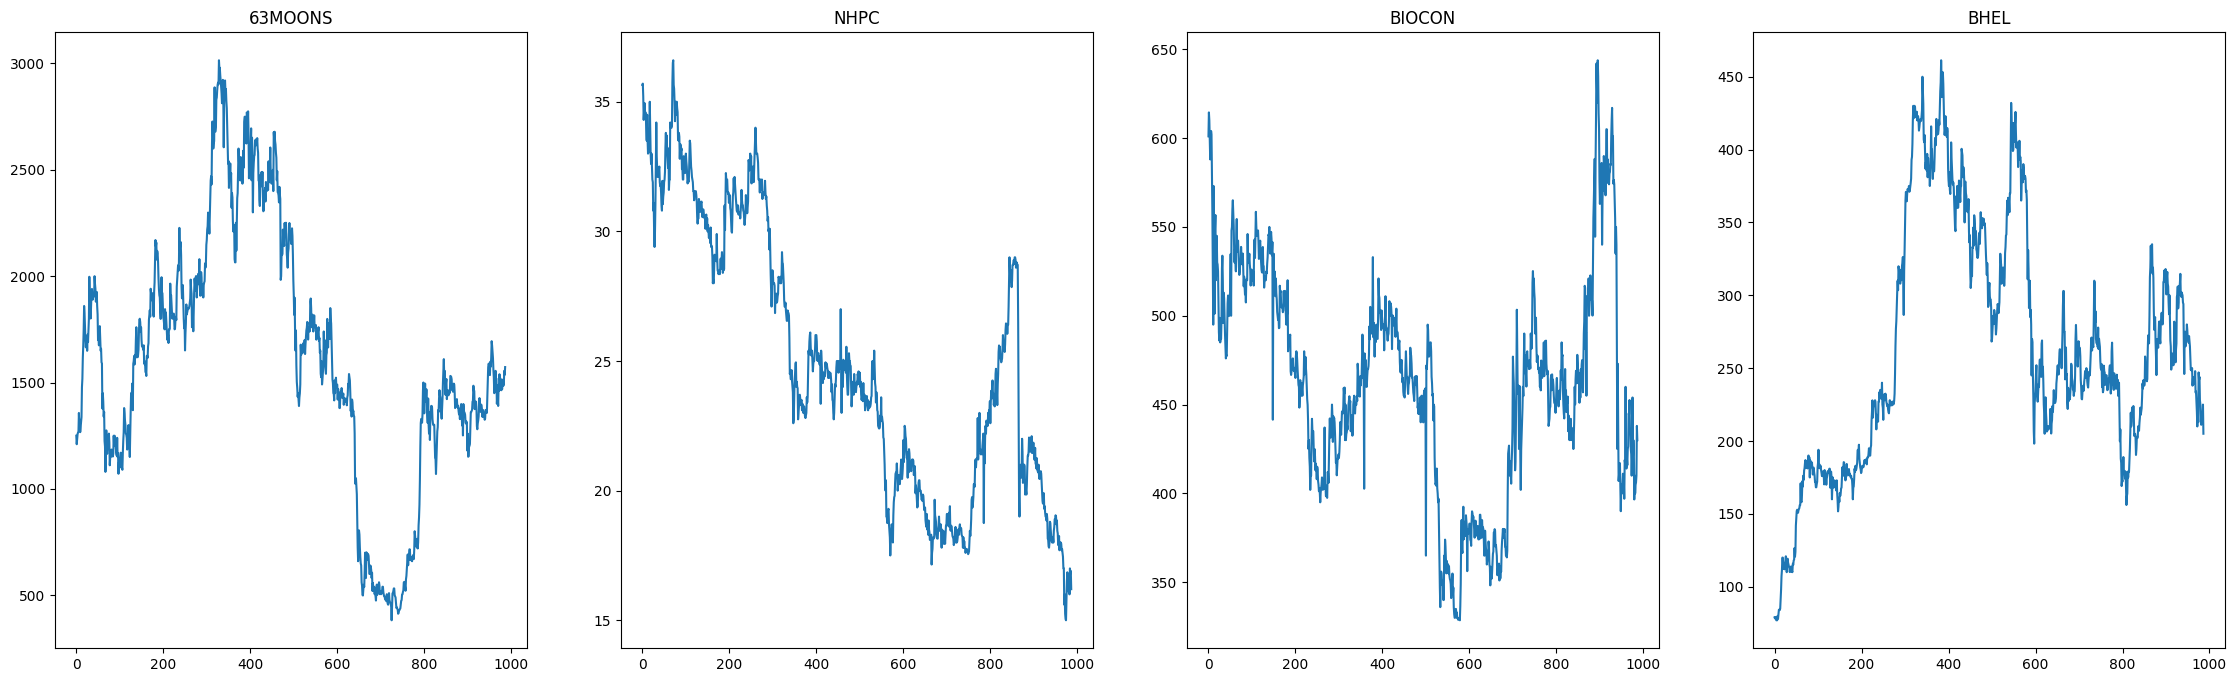

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df=dataframes,st=stocks):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
n = len(dataframes)
create_subplots(n,df=dataframes,st=stocks)

In [6]:

import itertools
num_stocks=len(dataframes)
boxes=2*(num_stocks-1)
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print(len(wt_combs_norm))


84


In [7]:
from Env import MultiTradingEnv;
LOOKBACK=1
step=0.05
positions=np.arange(0,1,step)
positions=np.append(positions,1)
print(positions)
env = MultiTradingEnv(dataframes_array=dataframes,
                      norm_dataframes=norm_dataframes,
                       total_timesteps=len(dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


# CODE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(env.action_space)
n_actions = env.num_stocks*len(env.positions)
n_weights=len(wt_combs_norm)
print(n_actions)
print(n_weights)
state = env.reset()
n_observations = len(state.features.flatten())

Discrete(4)
84
84


In [9]:
args = {
        'gamma': 0.99,
        'seed': 543,
        'render': False,
        'log_interval': 10
    }


SavedAction = namedtuple('SavedAction', ['log_prob', 'log_prob_weights', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic(action head, weight head and critic head) in one model
    """
    def __init__(self,n_observations):
        super(Policy, self).__init__()
        
        self.affine1 = nn.Linear(n_observations, 256)
        self.layer2=nn.Linear(256,128)
        # self.layer3=nn.Linear(128,128)

        # actor's layer
        self.action_head = nn.Linear(128, len(env.positions)*env.num_stocks)
        self.weight_head = nn.Linear(128, len(env.weight_combs))

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []


    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x = F.relu(self.layer2(x))
        # x = F.selu(self.layer3(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = (self.action_head(x)).view(-1, len(env.positions),env.num_stocks)
        action_prob=F.softmax(action_prob, dim=1)
        # action_prob = F.softmax(self.action_head(x), dim=-1)
        weight_prob = F.softmax(self.weight_head(x),dim=-1).view(-1, len(wt_combs_norm))
        # critic: evaluates being in the state s_t
        state_values = (self.value_head(x))
        
        

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, weight_prob, state_values

In [10]:
model = Policy(n_observations)
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    '''
        return both action and weight..
    '''

    # state = torch.from_numpy(state).float()
    probs, weight_probs, state_value = model(state)
    # create a categorical distribution over the list of probabilities of actions
    # print(probs)
    probs = probs.transpose(1, 2) 
    actions=[]
    for i in range(env.num_stocks):
        m = Categorical(probs[0][i]) 
        action=m.sample()
        actions.append(action.item())
    weight_m=Categorical(weight_probs[0])
    weight_action = weight_m.sample()

    # # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), weight_m.log_prob(weight_action), state_value))

    # # the action to take (left or right)
    return torch.tensor([actions]),torch.tensor([weight_action.item()])
    # return 0,0

# def select_weight(state):
#     state = torch.from_numpy(state).float()
#     probs, weight_probs, state_value = model(state)

#     # create a categorical distribution over the list of probabilities of actions
#     m = Categorical(probs)

#     # and sample an action using the distribution
#     action = m.sample()

#     # save to action buffer
#     model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

#     # the action to take (left or right)
#     return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    weight_losses = []
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + args['gamma'] * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, log_prob_weights, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)
        weight_losses.append(-log_prob_weights * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()+torch.stack(weight_losses).sum()

    # perform backprop
    loss.backward(retain_graph=True)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [11]:
def plot_durations(history, reward, ep, show_result=False):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    durations_t = torch.tensor(history, dtype=torch.float)
    dur_t=torch.tensor(reward, dtype=torch.float).cpu()
    
    if show_result:
        fig.suptitle('Result')
    else:
        fig.suptitle('Training...')
    
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Net Worth')
    axs[0].plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 5:
        means = durations_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        axs[0].plot(means.numpy())
    if len(dur_t) >= 5:
        means = dur_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        axs[1].plot(means.numpy())

    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Reward')
    # Plot reward data on the second subplot, you need to replace `reward_data` with your actual data
    axs[1].plot(dur_t.numpy())
    axs[2].plot(ep)
    # plt.tight_layout()
    plt.savefig('training.png')
    # plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     if not show_result:
    #         display.display(plt.gcf())
    #         display.clear_output(wait=True)
    #     else:
    #         display.display(plt.gcf())
    # plt.show()


In [12]:
running_reward = 10
# print(env.spec.max_episode_steps)
# env._max_episode_steps=500
# run infinitely many episodes
net_worth=[]
for i_episode in range(500):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0
    done=0
    
    while not done:

        # select action from policy
        # state = env.reset()
        state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
        # print(state)
        # break
        action, weight = select_action(state.view(-1).cpu())
        # print(action,weight)
        # break
        # take the action
        state, reward, done= env.step(action,weight)


        model.rewards.append(reward)
        ep_reward += reward
        env.render(episode_num=i_episode,reward=reward)
        if done:
            break
    print(ep_reward)
    net_worth.append(env.net_worth)
    ep=[env.history_array_episode[i][3] for i in range(len(env.history_array_episode))]
    plot_durations(net_worth,model.rewards,ep)
    # update cumulative reward
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

    # perform backprop
    finish_episode()

    # log results
    
    if i_episode % 1 == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                i_episode, env.net_worth, ep_reward))

    # check if we have "solved" the cart pole problem
    # if running_reward > env.spec.reward_threshold:
    #     print("Solved! Running reward is now {} and "
    #           "the last episode runs to {} time steps!".format(running_reward, t))
    #     break

KeyboardInterrupt: 

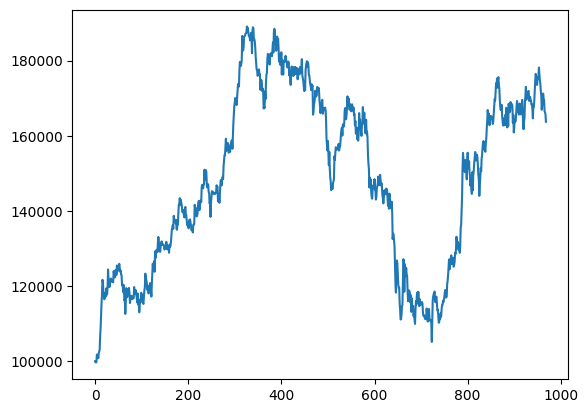

In [ ]:
state=env.reset()
done= 0
hist=[]
while not done:
    state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
    # print(state)
    # break
    action, weight,_ = model(state.view(-1))
    # print(action,weight)
    action = action.transpose(1, 2) 
    action=action.detach()
    weight=weight.detach()
    actions=[]
    for i in range(env.num_stocks):
        m = np.argmax(action[0][i]) 
        actions.append(m.item())
    weight_m=torch.tensor([np.argmax(weight).item()])
    act=torch.tensor([actions])
    # print(actions,weight_m)
    hist.append(env.net_worth)
    # break
    # take the action
    state, reward, done= env.step(act,weight_m)
plt.plot(hist)
plt.show()